<a href="https://colab.research.google.com/github/umbertodicanito/Stochastic-Training-of-Graph-Convolutional-Networks-with-Variance-Reduction/blob/master/CiteSeer_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

#Imports

In [0]:
!pip install dgl

     |████████████████████████████████| 2.4MB 3.5MB/s 


In [0]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from dgl import DGLGraph
from google.colab import files
import warnings
import matplotlib.pyplot as plt

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

#Building matrices for algorithm 1 execution

In [0]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_citeseer_data():
    data = citegrh.load_citeseer()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    mask = th.ByteTensor(data.train_mask)
    g = data.graph
    print(g)
    # add self loop
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask
    
#get data
g, features, labels, mask = load_citeseer_data()

Extracting file to /root/.dgl/citeseer
Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000



/usr/local/lib/python3.6/dist-packages/dgl/data/citation_graph.py:140: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [0]:
plain_deg_matrix = th.tensor(np.zeros((3327,3327)))
for i in range(3327):
  d = len(g.adjacency_matrix()[i]._indices()[0])
  plain_deg_matrix[i][i] = d

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [0]:
plain_deg_matrix

tensor([[2., 0., 0.,  ..., 0., 0., 0.],
        [0., 6., 0.,  ..., 0., 0., 0.],
        [0., 0., 2.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 4., 0., 0.],
        [0., 0., 0.,  ..., 0., 2., 0.],
        [0., 0., 0.,  ..., 0., 0., 2.]], dtype=torch.float64)

In [0]:
import math
deg_matrix = th.tensor(np.zeros((3327,3327)))
for i in range(3327):
  d = len(g.adjacency_matrix()[i]._indices()[0])
  deg_matrix[i][i] = math.pow(d,-0.5)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


This is the diagonal degree matrix.
This means that the degree of a node `'v'` with value `'d'`, is stored at `D[u][u]=d`, whereas all the other values of the matrix (except the diagonal) are equal to 0.

In [0]:
deg_matrix

tensor([[0.7071, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4082, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7071,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7071, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7071]],
       dtype=torch.float64)

In [0]:
g.adjacency_matrix().to_dense()

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

This is the propagation matrix P

In [0]:
P = th.mm(th.mm(deg_matrix.float(),g.adjacency_matrix().to_dense().float()),deg_matrix.float())
print(P.shape)
print(P)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


torch.Size([3327, 3327])
tensor([[0.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5000]])


The object `g` allows us to get more easily the neighboors nodes.


In [0]:
warnings.filterwarnings('ignore')
r = random.randint(0,3326)
print("Node " + str(r))
g.adjacency_matrix()[r]._indices()[0]

Node 1967


tensor([ 285,  582,  637,  721, 2066, 2312, 2672, 1967])

In [0]:
a = list(g.adjacency_matrix()[r]._indices()[0].numpy())
a.remove(r)
print(type(a))
print(a)

<class 'list'>
[285, 582, 637, 721, 2066, 2312, 2672]


This is a simple method used to transforma a list into a torch.Tensor object corresponding to a mask.

In [0]:
def createMask(array):
  a = []
  for i in range(3327):
    if i in array:
      a.append(1)
    else:
      a.append(0)
  m = th.ByteTensor(a)
  return m

#Implementing algorithm 1

The following algorithm is used in order to retrive the receptive fields of each layer and the propagation matrices for each layer, just for the selected minibath of nodes.

The algorithm is used in algorithm for training with CV approach.

Pseudo-code:



```
r_L = V_B
for layer l = L - 1 to 0 do
  r_l = 0
  P'_l = 0
  for each node u in r_l+1 do
    r_l = r_l + {u}
    P'_uu^l = P'_uu^l + P_uu*n(u)/D_l
    for D_l - 1 random neighbors v in n(u) do
      r_l = r_l + {v}
      P'_uv^l = P'_uv^l + P_uv*n(u)/D_l
    end for
  end for
end for
```
where


*   r_L: the receptive field of layer L
*   V_B: the minibatch set (a subset of nodes)
*   P'_l: propagation matrix of the layer l
*   P'_uv^l = P_uv^l * n(u)/D_l, if v is in n'(u)_l, otherwise 0
*   n(u): neighbors of u
*   n'(u): random subset of n(u)
*   D_l: neighbors for each node at layer l

Notice that, since we do not use MINIbatches, n(u)/D_l is always equal to 1.



In [0]:
import time
#implementation of the above algorithm#

#minibatch = th.ByteTensor(...) of 0,1 boolean (it is a mask)

#returning: the receptive fields and the propagation matrices
def algOne(minibatch):
  t0 = time.time()
  rL = minibatch
  l = 2
  n = 2

  receptiveField = dict()
  propagationMatrix = dict()

  receptiveField[l] = rL

  #first for-loop
  while l > 0:
    #init
    field = []
    matrixP = np.zeros((3327,3327))
    #second for-loop
    k = 0
    passedMask = False
    for nodeValue in receptiveField[l]:
      if nodeValue == 1:
        node = k

        if node not in field:
          field.append(node)

        matrixP[node][node] = matrixP[node][node] + P[node][node] * plain_deg_matrix[node][node] / n

        #collecting n random neighbor
        subset = []
        a = list(g.adjacency_matrix()[node]._indices()[0].numpy())
        a.remove(node)
        if len(a) <= n:
          subset = a
        else:
          subset = random.sample(a, k=n)

        #last for-loop
        for neighbor in subset:
          if neighbor not in field:
            field.append(neighbor)
          matrixP[node][neighbor] = matrixP[node][neighbor] + P[node][neighbor] * plain_deg_matrix[node][node] / n

      k = k + 1
      
    #updating level
    l = l - 1

    #convert field (array of nodes) to a mask
    receptiveField[l] = createMask(field).detach()
    propagationMatrix[l] = th.FloatTensor(matrixP).detach()
  
  #print(time.time() - t0)
  return [receptiveField, propagationMatrix]

#Model


Some commond parameters used to train the NN

In [0]:
n_of_training_cycles = 15
n_of_epochs = 150

This methods creates some random masks.

In [0]:
#random mask
masks = []
n_masks = 10
size_masks = 100
a = range(3327)
for i in range(n_masks):
  mask = np.zeros(3327)
  sub = random.sample(a,k=size_masks)
  for s in sub:
    mask[s] = 1
  m = th.ByteTensor(mask)
  masks.append(m)

print("Generated " + str(n_masks) + " random masks with size " + str(size_masks))

Generated 10 random masks with size 100


We then define the node UDF for ``apply_nodes``, which is a fully-connected layer:



In [0]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        z = self.linear(node.data['h'])
        h = self.activation(z)
        return {'h' : h}

We then proceed to define the GCN module. A GCN layer essentially performs
message passing on all the nodes then applies the `NodeApplyModule`. Note
that we omitted the dropout in the paper for simplicity.



In [0]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

The forward function is essentially the same as any other commonly seen NNs
model in PyTorch.  We can initialize GCN like any ``nn.Module``. For example,
let's define a simple neural network consisting of two GCN layers. Suppose we
are training the classifier for the CiteSeer dataset (the input feature size is
3703 and the number of classes is 6).



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(3703, 40, F.relu)
        self.gcn2 = GCN(40, 6, F.relu)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x
        
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=3703, out_features=40, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=40, out_features=6, bias=True)
    )
  )
)


We load the CiteSeer dataset using DGL's built-in data module.



We then train the network as follows:



This is the implementation of a standard GCN with 2 layers (+ 1 input layer). 

TEST --------------------------------------

In order to get the most effective learning rate for the CiteSeer set, running these cells multiple times will show comparison of performance between 4 different learning rates.

In [0]:
lrAccTest = dict()
lrLossTest = dict()

In [0]:
def updatePoints(index,accCS,lossCS, acc, loss):
  accPointsTest = [0]*30
  lossPointsTest = [0]*30

  for d in range(3):
    for i in range(30):
      accPointsTest[i] = accPointsTest[i] + accCS[d][i]
      lossPointsTest[i] = lossPointsTest[i] + lossCS[d][i]

  for i in range(30):
    accPointsTest[i] = accPointsTest[i]/3
    lossPointsTest[i] = lossPointsTest[i]/3
  
  acc[index] = accPointsTest
  loss[index] = lossPointsTest
  return [acc,loss]

In [0]:
import time
import collections
import numpy as np
warnings.filterwarnings('ignore')

#init counters
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
for actualLR in lrs:
  testAccCS = []
  testLossCS = []
  for t in range(3):
    print("Starting new training")
    #get data from DGL
    net = Net()
    g, features, labels, mask = load_citeseer_data()
    print(g)

    #point to show on graph
    pointsCiteSeer=dict()
    pointsLossCiteSeer=dict()

    #the number of masks to get when training per epoch
    n_masks_to_try = 4
    #initializing the optimizer (optimizer takes care of optimize the learining rate during training)
    optimizer = th.optim.Adam(net.parameters(), lr=actualLR)
    optimizer.state = collections.defaultdict(dict)

    #dur is just an array to store the duration in order to show them later
    dur = []

    for epoch in range(30):
        t0 = time.time()

        #getting only some masks (4)
        masksToTry = random.sample(masks,n_masks_to_try)

        for m in masksToTry:
            #calling 'net(...)' it asks to the GCN to compute the forward    

            logits = net(g, features)
            logp = F.log_softmax(logits, 1)

            #compute loss like the negative log likelihood loss
            loss = F.nll_loss(logp[m], labels[m])
            
            #Since the backward() function accumulates gradients, and you 
            #don’t want to mix up gradients between minibatch, you have 
            #to zero them out at the start of a new minibatch. This is 
            #exactly like how a general (additive) accumulator variable is 
            #initialized to 0 in code.
            optimizer.zero_grad()

            #update network weights by loss
            loss.backward()

            #update optimizer's values after backward
            optimizer.step()

            #computing accuracy
            i = 0
            matched = 0
            while i < 3327:
              if m[i] == 0:
                #getting index of the maximum
                j = 0
                max = None
                jMax = 0
                for a in logp[i]:
                  if max==None:
                    max = a.item()
                    jMax = j
                  elif max < a.item():
                    max = a.item()
                    jMax = j
                  j = j + 1
                if jMax == labels[i]:
                  matched = matched + 1
              i = i + 1
            acc = matched/(3327-size_masks)*100

            if epoch not in pointsCiteSeer:
              pointsCiteSeer[epoch] = 0
              pointsLossCiteSeer[epoch] = 0
            pointsCiteSeer[epoch] = pointsCiteSeer[epoch] + acc
            pointsLossCiteSeer[epoch] = pointsLossCiteSeer[epoch] + loss.item()
            
        dur.append(time.time() - t0)
        
        #computing the average of the accuracy and the loss
        pointsCiteSeer[epoch] = pointsCiteSeer[epoch]/n_masks_to_try
        pointsLossCiteSeer[epoch] = pointsLossCiteSeer[epoch]/n_masks_to_try

        print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f} %".format(
                epoch, loss.item(), np.mean(dur), pointsCiteSeer[epoch]))
    #storing results    
    testAccCS.append(pointsCiteSeer)
    testLossCS.append(pointsLossCiteSeer)
    print("Results stored.")
  print("New learning rate...")
  r = updatePoints(actualLR,testAccCS,testLossCS, lrAccTest, lrLossTest)
  lrAccTest = r[0]
  lrLossTest = r[1]


Starting new training
Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000

DGLGraph(num_nodes=3327, num_edges=12431,
         ndata_schemes={}
         edata_schemes={})
Epoch 00000 | Loss 2.2088 | Time(s) 2.6612 | Accuracy: 20.537651 %
Epoch 00001 | Loss 1.6446 | Time(s) 2.5940 | Accuracy: 14.758289 %
Epoch 00002 | Loss 1.5794 | Time(s) 2.5599 | Accuracy: 17.105671 %
Epoch 00003 | Loss 1.6883 | Time(s) 2.5443 | Accuracy: 27.835451 %
Epoch 00004 | Loss 1.4132 | Time(s) 2.5417 | Accuracy: 30.082120 %
Epoch 00005 | Loss 1.4902 | Time(s) 2.5433 | Accuracy: 31.848466 %
Epoch 00006 | Loss 1.2668 | Time(s) 2.5370 | Accuracy: 32.444995 %
Epoch 00007 | Loss 1.2001 | Time(s) 2.5320 | Accuracy: 34.071893 %
Epoch 00008 | Loss 1.2998 | Time(s) 2.5284 | Accuracy: 36.202355 %
Epoch 00009 | Loss 1.3690 | Time(s) 2.5256 | Accuracy: 37.077781 %
Epoch 00010 | Loss 1.3696 |

In [0]:
axisX = range(30)
colors = dict()
#lrs = [1e-1, 1e-2, 1e-3, 1e-4]
colors[1e-1] = "red"
colors[1e-2] = "orange"
colors[1e-3] = "blue"
colors[1e-4] = "green"

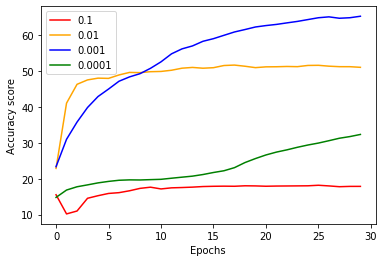

In [0]:
for lr in lrs:
  plt.plot(axisX, lrAccTest[lr], color = colors[lr], label=str(lr))
plt.ylabel("Accuracy score")
plt.xlabel("Epochs")
plt.legend()
plt.show()

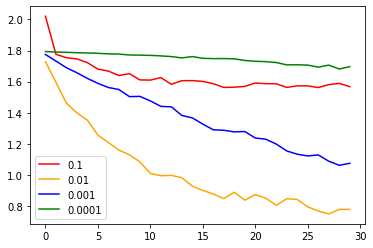

In [0]:
for lr in lrs:
  plt.plot(axisX, lrLossTest[lr], color = colors[lr], label=str(lr))
plt.legend()
plt.show()

TEST ^^^^^^^^^^^^^^^^^^^^^^^^^

In [0]:
import time
import collections
import numpy as np
warnings.filterwarnings('ignore')

#init counters
averageAccCiteSeer = []
averageLossCiteSeer = []

for t in range(n_of_training_cycles):
  print("Starting new training")
  #get data from DGL
  net = Net()
  g, features, labels, mask = load_citeseer_data()
  print(g)

  #point to show on graph
  pointsCiteSeer=dict()
  pointsLossCiteSeer=dict()

  #the number of masks to get when training per epoch
  n_masks_to_try = 4
  #initializing the optimizer (optimizer takes care of optimize the learining rate during training)
  optimizer = th.optim.Adam(net.parameters(), lr=2e-3)
  optimizer.state = collections.defaultdict(dict)

  #dur is just an array to store the duration in order to show them later
  dur = []

  #this 'for' cycles on 200 epochs
  for epoch in range(n_of_epochs):
      t0 = time.time()

      #getting only some masks (4)
      masksToTry = random.sample(masks,n_masks_to_try)

      for m in masksToTry:
          #calling 'net(...)' it asks to the GCN to compute the forward    

          logits = net(g, features)
          logp = F.log_softmax(logits, 1)

          #compute loss like the negative log likelihood loss
          loss = F.nll_loss(logp[m], labels[m])
          
          #Since the backward() function accumulates gradients, and you 
          #don’t want to mix up gradients between minibatch, you have 
          #to zero them out at the start of a new minibatch. This is 
          #exactly like how a general (additive) accumulator variable is 
          #initialized to 0 in code.
          optimizer.zero_grad()

          #update network weights by loss
          loss.backward()

          #update optimizer's values after backward
          optimizer.step()

          #computing accuracy
          i = 0
          matched = 0
          while i < 3327:
            if m[i] == 0:
              #getting index of the maximum
              j = 0
              max = None
              jMax = 0
              for a in logp[i]:
                if max==None:
                  max = a.item()
                  jMax = j
                elif max < a.item():
                  max = a.item()
                  jMax = j
                j = j + 1
              if jMax == labels[i]:
                matched = matched + 1
            i = i + 1
          acc = matched/(3327-size_masks)*100

          if epoch not in pointsCiteSeer:
            pointsCiteSeer[epoch] = 0
            pointsLossCiteSeer[epoch] = 0
          pointsCiteSeer[epoch] = pointsCiteSeer[epoch] + acc
          pointsLossCiteSeer[epoch] = pointsLossCiteSeer[epoch] + loss.item()
          
      dur.append(time.time() - t0)
      
      #computing the average of the accuracy and the loss
      pointsCiteSeer[epoch] = pointsCiteSeer[epoch]/n_masks_to_try
      pointsLossCiteSeer[epoch] = pointsLossCiteSeer[epoch]/n_masks_to_try

      print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f} %".format(
              epoch, loss.item(), np.mean(dur), pointsCiteSeer[epoch]))
  #storing results    
  averageAccCiteSeer.append(pointsCiteSeer)
  averageLossCiteSeer.append(pointsLossCiteSeer)
  print("Results stored.")

Starting new training
Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000

DGLGraph(num_nodes=3327, num_edges=12431,
         ndata_schemes={}
         edata_schemes={})
Epoch 00000 | Loss 1.7861 | Time(s) 2.4925 | Accuracy: 21.087698 %
Epoch 00001 | Loss 1.7612 | Time(s) 2.4954 | Accuracy: 28.199566 %
Epoch 00002 | Loss 1.7194 | Time(s) 2.5169 | Accuracy: 33.746514 %
Epoch 00003 | Loss 1.7088 | Time(s) 2.5104 | Accuracy: 35.706539 %
Epoch 00004 | Loss 1.5936 | Time(s) 2.5070 | Accuracy: 36.690425 %
Epoch 00005 | Loss 1.5727 | Time(s) 2.5149 | Accuracy: 37.387667 %
Epoch 00006 | Loss 1.4993 | Time(s) 2.5225 | Accuracy: 37.790518 %
Epoch 00007 | Loss 1.4771 | Time(s) 2.5246 | Accuracy: 38.727921 %
Epoch 00008 | Loss 1.5272 | Time(s) 2.5184 | Accuracy: 39.115277 %
Epoch 00009 | Loss 1.4025 | Time(s) 2.5170 | Accuracy: 39.990703 %
Epoch 00010 | Loss 1.3303 |

#On graphic

In [0]:
accPointsCiteSeer = [0]*n_of_epochs
lossPointsCiteSeer = [0]*n_of_epochs

for d in range(n_of_training_cycles):
  for i in range(n_of_epochs):
    accPointsCiteSeer[i] = accPointsCiteSeer[i] + averageAccCiteSeer[d][i]
    lossPointsCiteSeer[i] = lossPointsCiteSeer[i] + averageLossCiteSeer[d][i]

for i in range(n_of_epochs):
  accPointsCiteSeer[i] = accPointsCiteSeer[i]/n_of_training_cycles
  lossPointsCiteSeer[i] = lossPointsCiteSeer[i]/n_of_training_cycles

In [0]:
maxAccCiteSeer = np.argmax(accPointsCiteSeer)
maxAccCiteSeer

114

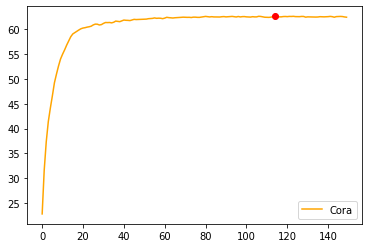

In [0]:
axisX = range(n_of_epochs)

plt.plot(axisX, accPointsCiteSeer, color='orange', label='CiteSeer')
#plt.plot(axisX, pointsPubMed, color='blue', label='PubMed')
plt.plot([maxAccCiteSeer], accPointsCiteSeer[maxAccCiteSeer], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsPubMed[maxAccPubMed], marker='o', color='blue')
plt.legend()
plt.show()

In [0]:
print("Max accuracy CiteSeer at {:03d} epochs with value {:05f}"
  .format(maxAccCiteSeer, pointsCiteSeer[maxAccCiteSeer]))
#print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
#  .format(maxAccPubMed, pointsPubMed[maxAccPubMed]))

Max accuracy Cora at 114 epochs with value 32.290053


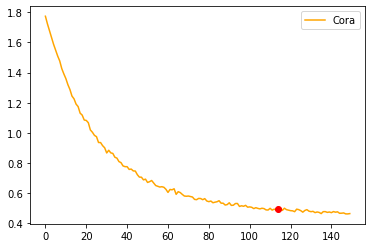

In [0]:
plt.plot(axisX, lossPointsCiteSeer, color='orange', label='CiteSeer')
#plt.plot(axisX, pointsLossPubMed, color='blue', label='PubMed')
plt.plot([maxAccCiteSeer], lossPointsCiteSeer[maxAccCiteSeer], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsLossPubMed[maxAccPubMed].item(), marker='o',color='blue')
plt.legend()
plt.show()

In [0]:
print("For CiteSeer, at epoch {:03d}, loss was {:05f}"
  .format(maxAccCiteSeer, lossPointsCiteSeer[maxAccCiteSeer]))
#print("For PubMed, at epoch {:03d}, loss was {:05f}"
#  .format(maxAccPubMed, pointsLossPubMed[maxAccPubMed]))

For Cora, at epoch 114, loss was 0.493107


#Our algorithm

For our algorithm we need to store somewhere some information. In particular for each training cycle we will update the historical activation in order to bring an efficent approximation. Also, we need to store the last recent h_0 and h_1, for computational purpose.

In [0]:
#  NumNodes: 3327
#  NumEdges: 9228
#  NumFeats: 3703

class HMatrices():
  def __init__(self):
    self.historical_activation_1 = th.Tensor(np.zeros((3327,3703)))
    self.historical_activation_2 = th.Tensor(np.zeros((3327,40)))
    self.h_0 = th.Tensor([])
    self.h_1 = th.Tensor([])

  def updateHMatrix(self,features,x):
    self.h_0 = features
    self.h_1 = x
  
  def updateActivation(self, row, level, a):
    if level == 0:
      self.historical_activation_1[row] = a
    elif level == 1:
      self.historical_activation_2[row] = a

In [0]:
class SimpleNodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(SimpleNodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        #type of node: dgl.udf.NodeBatch
        #type of node.data['h']: torch.Tensor
        z = self.linear(node.data['h'])
        h = self.activation(z)
        return {'h' : h}

In [0]:
class SimpleGCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(SimpleGCN, self).__init__()
        self.apply_mod = SimpleNodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [0]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.gcn1 = SimpleGCN(3703, 40, F.relu)
        self.gcn2 = SimpleGCN(40, 6, F.relu)

    def forward(self, g, features, propMatrix, historicalActivation, hContainer):
        #type of 'g': dgl.graph.DGLGraph
        x = self.gcn1(g, features)
        hContainer.updateHMatrix(features, x)
        # CV = (P'_l*(H_l-H'_l)+P*H'_l)
        x = th.mm(propMatrix,x.sub(historicalActivation)).add(th.mm(P,historicalActivation))
        x = self.gcn2(g, x)
        return x

simpleNet = SimpleNet()
print(simpleNet)

SimpleNet(
  (gcn1): SimpleGCN(
    (apply_mod): SimpleNodeApplyModule(
      (linear): Linear(in_features=3703, out_features=40, bias=True)
    )
  )
  (gcn2): SimpleGCN(
    (apply_mod): SimpleNodeApplyModule(
      (linear): Linear(in_features=40, out_features=6, bias=True)
    )
  )
)


In [0]:
import time
import collections
import numpy as np
warnings.filterwarnings('ignore')

#init counters
averageAccCiteSeer_our = []
averageLossCiteSeer_our = []

for t in range(1):
  print("Starting new training cycle")

  simpleNet = SimpleNet()
  #point to show on graph
  pointsOurCiteSeer=dict()
  pointsOurLossCiteSeer=dict()

  with th.no_grad():
    #get data
    g, features, labels, mask = load_citeseer_data()

    print(g)
    n_masks_to_try = 4
    ourOptimizer = th.optim.Adam(simpleNet.parameters(), lr=2e-3)
    ourOptimizer.state = collections.defaultdict(dict)
    dur = []

    #running algOne for each mask
    t0 = time.time()
    print("Computing algorithm 1 for each mask...")
    resForMasks = dict()
    for m in masks:
      resForMasks[m] = algOne(m)
    print("{:03f} seconds".format(time.time()-t0))

  #this is an object storing some constant data
  hs = HMatrices()

  for epoch in range(n_of_epochs):
        
      t0 = time.time()
      #getting only some masks (4)
      masksToTry = random.sample(masks,n_masks_to_try)
      for m in masksToTry:
          #calling 'net(...)' it asks to the GCN to compute the forward

          #M=(P'_l*(H_l-H'_l)+P*H'_l)
          #H_l = feature
          #P': progationMatrix
          #H': get from initialized matrix
          #P: computed before
          CV = th.mm(resForMasks[m][1][0],features.sub(hs.historical_activation_1.detach())).add(th.mm(P,hs.historical_activation_1.detach()))
          logits = simpleNet(g, CV, resForMasks[m][1][1], hs.historical_activation_2.detach(), hs)
          logp = F.log_softmax(logits, 1)

          #compute loss like the negative log likelihood loss
          ourLoss = F.nll_loss(logp[m], labels[m])

          #Since the backward() function accumulates gradients, and you 
          #don’t want to mix up gradients between minibatch, you have 
          #to zero them out at the start of a new minibatch. This is 
          #exactly like how a general (additive) accumulator variable is 
          #initialized to 0 in code.
          ourOptimizer.zero_grad()

          #update network weights by loss
          #ourLoss.backward(retain_graph=True)
          ourLoss.backward()

          #update optimizer's values after backward
          ourOptimizer.step()

          #computing accuracy
          i = 0
          matched = 0
          while i < 3327:
            if m[i] == 0:
              #getting index of the maximum
              j = 0
              max = None
              jMax = 0
              for a in logp[i]:
                if max==None:
                  max = a.item()
                  jMax = j
                elif max < a.item():
                  max = a.item()
                  jMax = j
                j = j + 1
              if jMax == labels[i]:
                matched = matched + 1
            i = i + 1
          acc = matched/(3327-size_masks)*100

          if epoch not in pointsOurCiteSeer:
            pointsOurCiteSeer[epoch] = 0
            pointsOurLossCiteSeer[epoch] = 0
          pointsOurCiteSeer[epoch] = pointsOurCiteSeer[epoch] + acc
          pointsOurLossCiteSeer[epoch] = pointsOurLossCiteSeer[epoch] + ourLoss.item()
          
          #update historical activation
          for i in range(2):
            recField = resForMasks[m][0][i]
            k = 0
            if i == 0:
              for n in recField:
                if n == 1:
                  hs.updateActivation(k,i,hs.h_0[k])
                k = k + 1
            elif i == 1:
              for n in recField:
                if n == 1:
                  hs.updateActivation(k,i,hs.h_1[k])
                k = k + 1

      dur.append(time.time() - t0)
      
      pointsOurCiteSeer[epoch] = pointsOurCiteSeer[epoch]/n_masks_to_try
      pointsOurLossCiteSeer[epoch] = pointsOurLossCiteSeer[epoch]/n_masks_to_try

      print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f}".format(
              epoch, ourLoss.item(), np.mean(dur), pointsOurCiteSeer[epoch]))
  
  averageAccCiteSeer_our.append(pointsOurCiteSeer)
  averageLossCiteSeer_our.append(pointsOurLossCiteSeer)
  print("Results stored")

Starting new training cycle
Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000

DGLGraph(num_nodes=3327, num_edges=12431,
         ndata_schemes={}
         edata_schemes={})
Computing algorithm 1 for each mask...
6.300874 seconds
Epoch 00000 | Loss 1.7846 | Time(s) 13.1385 | Accuracy: 9.792377
Epoch 00001 | Loss 1.7477 | Time(s) 13.1093 | Accuracy: 23.682987
Epoch 00002 | Loss 1.7169 | Time(s) 13.1055 | Accuracy: 33.064766
Epoch 00003 | Loss 1.6717 | Time(s) 13.0786 | Accuracy: 38.898358
Epoch 00004 | Loss 1.5786 | Time(s) 13.0752 | Accuracy: 41.764797
Epoch 00005 | Loss 1.5600 | Time(s) 13.0691 | Accuracy: 43.290982
Epoch 00006 | Loss 1.5341 | Time(s) 13.0802 | Accuracy: 43.089557
Epoch 00007 | Loss 1.5357 | Time(s) 13.0903 | Accuracy: 43.035327
Epoch 00008 | Loss 1.4436 | Time(s) 13.1058 | Accuracy: 43.438178
Epoch 00009 | Loss 1.4919 | Time(s) 13.114

#On graphic (our algorithm)

In [0]:
accPointsCiteSeer_our = [0]*n_of_epochs
lossPointsCiteSeer_our = [0]*n_of_epochs

for d in range(n_of_training_cycles):
  for i in range(n_of_epochs):
    accPointsCiteSeer_our[i] = accPointsCiteSeer_our[i] + averageAccCiteSeer_our[d][i]
    lossPointsCiteSeer_our[i] = lossPointsCiteSeer_our[i] + averageLossCiteSeer_our[d][i]

for i in range(n_of_epochs):
  accPointsCiteSeer_our[i] = accPointsCiteSeer_our[i]/n_of_training_cycles
  lossPointsCiteSeer_our[i] = lossPointsCiteSeer_our[i]/n_of_training_cycles

In [0]:
maxAccCiteSeer_our = np.argmax(accPointsCiteSeer_our)
maxAccCiteSeer_our

115

Accuracy of our algorithm

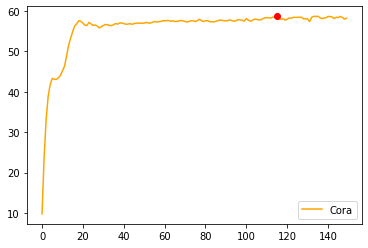

In [0]:
axisX = range(n_of_epochs)

plt.plot(axisX, accPointsCiteSeer_our, color='orange', label='CiteSeer')
#plt.plot(axisX, pointsPubMed, color='blue', label='PubMed')
plt.plot([maxAccCiteSeer_our], accPointsCiteSeer_our[maxAccCiteSeer_our], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsPubMed[maxAccPubMed], marker='o', color='blue')
plt.legend()
plt.show()

In [0]:
print("Max accuracy CiteSeer at {:03d} epochs with value {:05f}"
  .format(maxAccCiteSeer_our, accPointsCiteSeer_our[maxAccCiteSeer_our]))
#print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
#  .format(maxAccPubMed, pointsPubMed[maxAccPubMed]))

Max accuracy Cora at 115 epochs with value 58.661295


Loss values of our algorithm

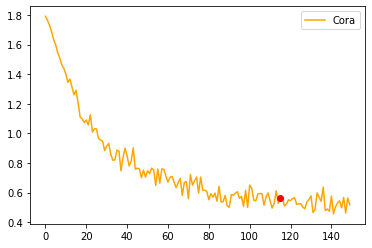

In [0]:
plt.plot(axisX, lossPointsCiteSeer_our, color='orange', label='CiteSeer')
#plt.plot(axisX, pointsLossPubMed, color='blue', label='PubMed')
plt.plot([maxAccCiteSeer_our], lossPointsCiteSeer_our[maxAccCiteSeer_our], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsLossPubMed[maxAccPubMed].item(), marker='o',color='blue')
plt.legend()
plt.show()

In [0]:
print("For CiteSeer, at epoch {:03d}, loss was {:05f}"
  .format(maxAccCiteSeer_our, lossPointsCiteSeer_our[maxAccCiteSeer_our]))
#print("For PubMed, at epoch {:03d}, loss was {:05f}"
#  .format(maxAccPubMed, pointsLossPubMed[maxAccPubMed]))

For Cora, at epoch 115, loss was 0.565999


#Comparison

Comparison between accuracy of both algorithms. The red dots show the maximum values reached.

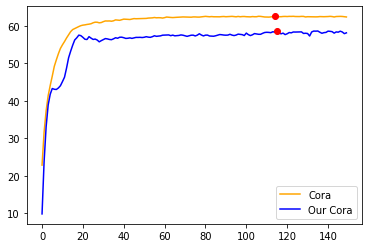

In [0]:
plt.plot(axisX, accPointsCiteSeer, color='orange', label='CiteSeer')
plt.plot(axisX, accPointsCiteSeer_our, color='blue', label='Our CiteSeer')
plt.plot([maxAccCiteSeer], accPointsCiteSeer[maxAccCiteSeer], marker='o', color ='red')
plt.plot([maxAccCiteSeer_our], accPointsCiteSeer_our[maxAccCiteSeer_our], marker='o', color='red')

plt.legend()
plt.show()

Comparison between the loss values of both algorithm. The red dots shows the loss values when the accuracy is at its maximum.

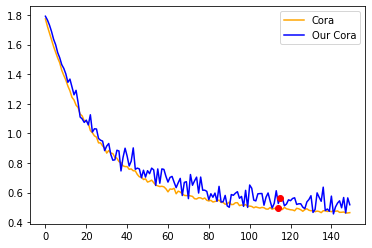

In [0]:
plt.plot(axisX, lossPointsCiteSeer, color='orange', label='CiteSeer')
plt.plot(axisX, lossPointsCiteSeer_our, color='blue', label='Our CiteSeer')
plt.plot([maxAccCiteSeer], lossPointsCiteSeer[maxAccCiteSeer], marker='o', color ='red')
plt.plot([maxAccCiteSeer_our], lossPointsCiteSeer_our[maxAccCiteSeer_our], marker='o', color='red')

plt.legend()
plt.show()